# ASE Interface


The Atomic Simulation Environment (ASE) is a toolkit for atomistic simulations. molify extends ASE by adding chemical connectivity and thereby enabling the integration with rdkit.

For more information about ASE, visit https://wiki.fysik.dtu.dk/ase/

In [1]:
import ase.build
from IPython.display import display

import molify

## Creating Structures from SMILES

molify provides convenient functions to generate ASE Atoms objects directly from SMILES strings.

### `smiles2atoms()`: single 3D structure

In [2]:
# Create an aldehyde molecule from SMILES with hydrogens.
aldehyde = molify.smiles2atoms("C=O")

print(f"Aldehyde molecule: {aldehyde}")
print(f"Positions:\n{aldehyde.positions}")
print("\nStored information:")
print(f"  SMILES: {aldehyde.info['smiles']}")
print(f"  Number of bonds: {len(aldehyde.info['connectivity'])}")

Aldehyde molecule: Atoms(symbols='COH2', pbc=False)
Positions:
[[-4.46780196e-02 -1.74057025e-02  7.86262348e-04]
 [ 1.17780391e+00 -1.52289849e-01 -1.78379214e-02]
 [-3.97811548e-01  1.00725032e+00  1.49697709e-03]
 [-7.35314340e-01 -8.37554770e-01  1.55546820e-02]]

Stored information:
  SMILES: C=O
  Number of bonds: 3


Note: When created from SMILES, the molecule automatically includes:
- ✅ 3D coordinates (from RDKit's embedding)
- ✅ Explicit `connectivity` in `atoms.info`
- ✅ SMILES string in `atoms.info`

### `smiles2conformers()`: Multiple 3D Conformers

Generate multiple conformers for conformational sampling:

In [3]:
# Generate 3 conformers of ethanol
ethanol_conformers = molify.smiles2conformers("CCO", numConfs=3)

print(f"Generated {len(ethanol_conformers)} conformers \n")
for i, conf in enumerate(ethanol_conformers):
    print(f"  Conformer {i + 1}: {conf}")

Generated 3 conformers 

  Conformer 1: Atoms(symbols='C2OH6', pbc=False)
  Conformer 2: Atoms(symbols='C2OH6', pbc=False)
  Conformer 3: Atoms(symbols='C2OH6', pbc=False)


In [4]:
# All conformers have the same connectivity
for i, conf in enumerate(ethanol_conformers, 1):
    print(f"  Conformer {i}: {len(conf.info['connectivity'])} bonds")

  Conformer 1: 8 bonds
  Conformer 2: 8 bonds
  Conformer 3: 8 bonds


## ASE → RDKit: The Direct Path (With Connectivity)

When ASE Atoms have connectivity information, conversion to RDKit is straightforward:

Aspirin molecule:


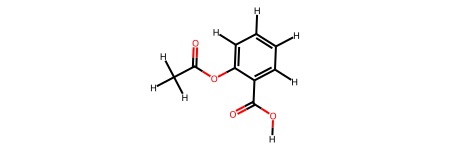

In [ ]:
# Create aspirin from SMILES
aspirin = molify.smiles2atoms("CC(=O)Oc1ccccc1C(=O)O")

# Convert to RDKit (exact with existing connectivity data)
aspirin_mol = molify.ase2rdkit(aspirin)

print("Aspirin molecule:")
display(aspirin_mol)

Internally, `ase2rdkit()` uses:
1. `ase2networkx()` - transfers connectivity to graph
2. `networkx2rdkit()` - converts graph to RDKit molecule

When the full connectivity including the bond_order exists in `atoms.info`, this conversion does not require any bond guessing.

## ASE → NetworkX: Bond Detection from Geometry

When `atoms.info['connectivity']` is **not** present, molify will **infer bonds** from atomic positions using covalent radii when converting ASE Atoms to NetworkX graphs.

### Case 1: With Explicit Connectivity

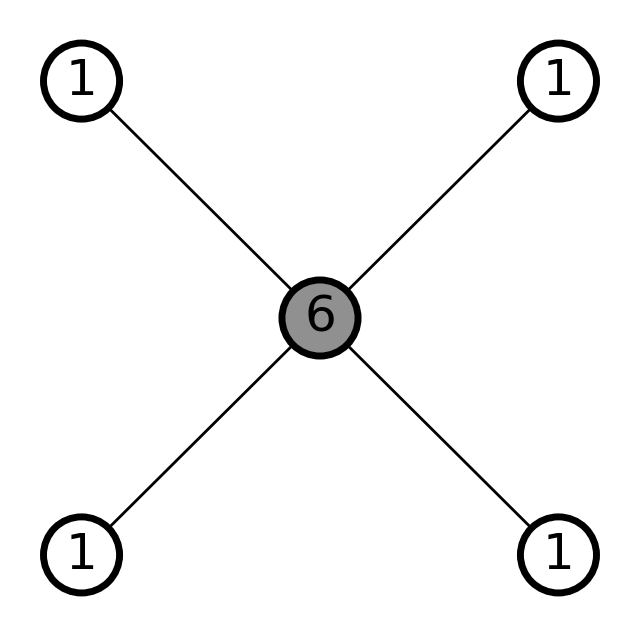

In [6]:
# Create methane with connectivity
methane = molify.smiles2atoms("C")

# Convert to NetworkX - uses explicit connectivity
graph_with_connectivity = molify.ase2networkx(methane)

# Draw the graph using molify's draw_molecular_graph utility
_ = molify.draw_molecular_graph(
    graph_with_connectivity,
)

### Case 2: Without Connectivity (Bond Detection Required)

This example simulates what happens when connectivity information is missing:

In [7]:
# Create a molecule and remove connectivity
ammonia = ase.build.molecule("NH3")

print(f"{ammonia.info = }")

ammonia.info = {}


In [8]:
# The connectivity is infered from the covalent radii scaled by 1.2
# this method does not determine the type of the bond (bond order).
graph_without_connectivity = molify.ase2networkx(ammonia, scale=1.2)

print(f"Nodes: {graph_without_connectivity.number_of_nodes()}")
print(f"Edges: {graph_without_connectivity.number_of_edges()}")
print("\nEdge attributes (all bonds):")
for u, v, data in graph_without_connectivity.edges(data=True):
    print(f"  Bond: atom {u} - atom {v}, bond_order = {data['bond_order']}")

Nodes: 4
Edges: 3

Edge attributes (all bonds):
  Bond: atom 0 - atom 1, bond_order = None
  Bond: atom 0 - atom 2, bond_order = None
  Bond: atom 0 - atom 3, bond_order = None


### How Bond Detection Works

When connectivity is not available, `ase2networkx()` uses:

1. **Covalent Radii**: Each element has a characteristic covalent radius
2. **Scaling Factor**: Default `scale=1.2` multiplies these radii
3. **Distance Check**: Two atoms are bonded if:
   ```python
   distance <= (radius_1 + radius_2) * scale
   ```
   This includes bonds over periodic boundaries.
4. **Special Handling**: Excludes typically non-bonding ions (Li, Na, K, Rb, Cs, Fr)

The following demonstrates the `scale` parameter in action:

scale=0.7: 0 bonds detected
scale=1.2: 3 bonds detected
scale=3: 6 bonds detected


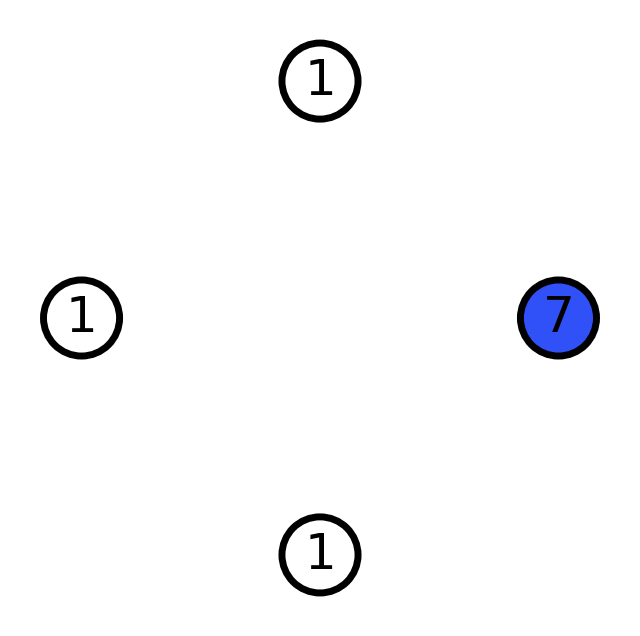

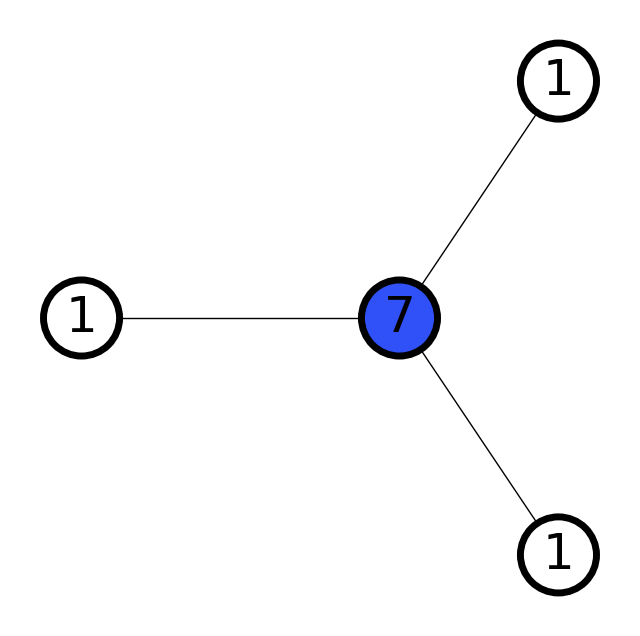

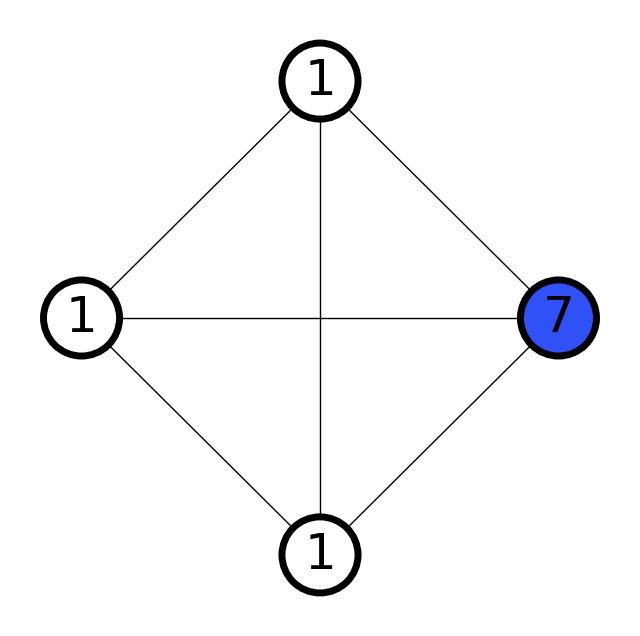

In [9]:
# Try different scale values
scales = [0.7, 1.2, 3]

for scale in scales:
    graph = molify.ase2networkx(ammonia, scale=scale)
    _ = molify.draw_molecular_graph(graph)
    print(f"scale={scale}: {graph.number_of_edges()} bonds detected")

## Working with Molecules from Collections

Here are some additional examples, based on
ASE's molecule databases. The following converts some of these to RDKit for visualization and analysis:


PH3:


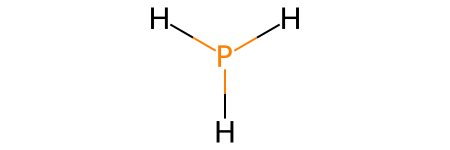


P2:


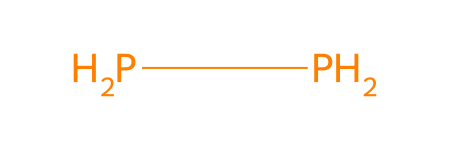


CH3CHO:


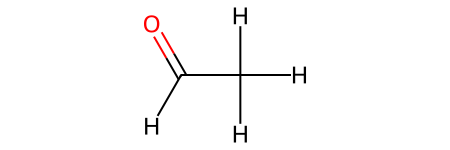


H2COH:


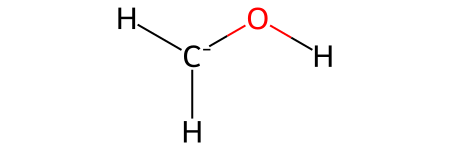


CS:


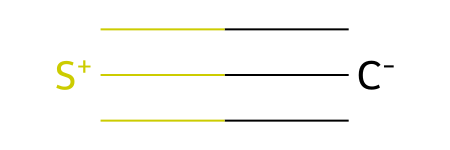

In [10]:
from ase.collections import g2

# Show a few molecules from the G2 database
for idx, (atoms, name) in enumerate(zip(g2, g2.names)):
    if idx >= 5:  # Show first 5
        break

    print(f"\n{name}:")
    # Note: These molecules don't have connectivity, so we need suggestions
    # We'll learn more about this in the NetworkX tools section
    mol = molify.ase2rdkit(atoms, suggestions=[])
    display(mol)

## Key Takeaways

### What We Learned

1. **Creating structures**:
   - `smiles2atoms()` - single conformer with connectivity
   - `smiles2conformers()` - multiple conformers
   - Both include explicit connectivity information

2. **Bond detection from geometry** (when connectivity is missing):
   - Uses covalent radii × `scale` factor (default 1.2)
   - Results in `bond_order=None` in NetworkX edges
   - `atoms.pbc` parameter controls periodic boundary handling

### Important Concepts

- `bond_order=None` means "bond exists but type is unknown"
- This happens when inferring bonds from distances